In [1]:
cd ..

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier


In [5]:
from src.d04_mixmatch.wideresnet import WideResNet
from src.d02_data.load_data import get_dataloaders_validation
from src.d03_processing.transform_data import AddGaussianNoise, Augment
from src.d07_visualization.visualize_cifar10 import show_img
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import time

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


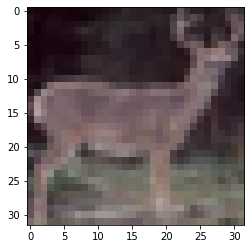

In [4]:
# Get data
train_loader, val_loader, test_loader = get_dataloaders_validation(path='data', 
                                                                   batch_size=64, train_size=1000, val_size=0)
show_img(iter(train_loader).next()[0][0])

In [8]:
# Init new model
model = WideResNet(depth=28, k=2, n_out=10)


In [16]:
# Load saved model
model_name = 'model_fs_adam.pt'
saved_model = torch.load(f'models/saved_models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10)
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

In [22]:
class MixMatch(object):

    def __init__(self, model, batch_size, device='cpu', T=0.5, K=2, alpha=0.75):
        self.T = T
        self.K = K
        self.batch_size = batch_size
        self.alpha = alpha
        self.softmax = nn.Softmax(dim=1)
        self.model = model
        self.device = device
        self.n_labels = 10  # Warning! hardcoded
        self.beta = torch.distributions.beta.Beta(alpha, alpha)

    def run(self, x_imgs, x_labels, u_imgs):
        # One hot encoding
        x_labels = self.one_hot_encoding(x_labels)
        x_labels.to(self.device)

        # Augment
        augment_once = Augment(K=1)
        augment_k = Augment(K=self.K)

        x_hat = augment_once(x_imgs)  # shape (1, batch_size, 3, 32, 32)
        u_hat = augment_k(u_imgs)     # shape (K, batch_size, 3, 32, 32)

        # Generate guessed labels
        q_bar = self.guess_label(u_hat)
        q = self.sharpen(q_bar)  # shape (K, batch_size, 10)

        x_hat = x_hat.reshape((-1, 3, 32, 32))  # shape (batch_size, 3, 32, 32)
        u_hat = u_hat.reshape((-1, 3, 32, 32))  # shape (K*batch_size, 3, 32, 32)
        q = q.repeat(self.K, 1, 1).reshape(-1, 10)  # shape (K*batch_size, 10)

        # Concat and shuffle
        w_imgs = torch.cat((x_hat, u_hat))
        w_labels = torch.cat((x_labels, q))
        w_imgs, w_labels = self.shuffle_matrices(w_imgs, w_labels)

        # Apply MixUp
        x_prime, p_prime = self.mixup(x_hat, w_imgs[:self.batch_size], x_labels, w_labels[:self.batch_size])
        u_prime, q_prime = self.mixup(u_hat, w_imgs[self.batch_size:], q, w_labels[self.batch_size:])

        return (x_prime, p_prime), (u_prime, q_prime)

    def mixup(self, x1, x2, p1, p2):
        n_samples = x1.shape[0]
        lambda_rand = self.beta.sample([n_samples, 1, 1, 1]).to(self.device)  # one lambda per sample
        lambda_prime = torch.max(lambda_rand, 1 - lambda_rand).to(self.device)
        x_prime = lambda_prime * x1 + (1 - lambda_prime) * x2
        lambda_prime = lambda_prime.reshape(-1, 1)
        p_prime = lambda_prime * p1 + (1 - lambda_prime) * p2
        return x_prime, p_prime

    def sharpen(self, q_bar):
        #q_bar = q_bar.numpy()
        q = torch.pow(q_bar, 1 / self.T) / torch.sum(torch.pow(q_bar, 1 / self.T), axis=1)[:, np.newaxis]
        return q

    def guess_label(self, u_hat):
        self.model.eval()
        with torch.no_grad():
            q_bar = torch.zeros([self.batch_size, self.n_labels], device=self.device)
            for k in range(self.K):
                q_bar += self.softmax(self.model(u_hat[k]))
            q_bar /= self.K

        self.model.train()
        return q_bar

    def one_hot_encoding(self, labels):
        shape = (labels.shape[0], self.n_labels)
        one_hot = torch.zeros(shape, dtype=torch.float32, device=self.device)
        rows = torch.arange(labels.shape[0])
        one_hot[rows, labels] = 1
        return one_hot

    # shuffles along the first axis (axis 0)
    def shuffle_matrices(self, m1, m2):
        n_samples = m1.shape[0]
        rand_indexes = torch.randperm(n_samples)
        m1 = m1[rand_indexes]
        m2 = m2[rand_indexes]
        return m1, m2

In [55]:
x_imgs, x_labels = iter(train_loader).next()
u_imgs, _ = iter(train_loader).next()

mixmatch = MixMatch(model, 64)
x, u = mixmatch.run(x_imgs, x_labels, u_imgs)
loss_mixmatch = Loss(75, 16000)

x_in = x[0]
x_lbl = x[1]
u_in = u[0]
u_lbl = u[1]

x_out = model(x_in)
u_out = model(u_in)

print(x_out.shape)
print(x_lbl.shape)
print(u_out.shape)
print(u_lbl.shape)

loss, lx, lu_w = loss_mixmatch(x_out, x_lbl, u_out, u_lbl, 16000)
print('Loss: ' + str(loss))
print('Lx: ' + str(lx))
print('Lu_w: ' + str(lu_w))


torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([128, 10])
torch.Size([128, 10])
tensor([-1.8210, -3.8468, -1.9981, -1.9374, -4.6211, -3.0657, -3.6808, -3.5633,
        -0.9482, -3.2271], grad_fn=<SelectBackward>)
Loss: 3.470468044281006
Lx: 1.8065435886383057
Lu_w: 1.6639243364334106


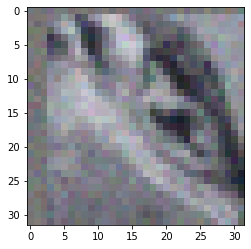

tensor([0.1001, 0.0999, 0.1000, 0.1000, 0.0999, 0.0999, 0.0999, 0.0999, 0.1003,
        0.0999], grad_fn=<SelectBackward>)
tensor([1.3048e-14, 3.2468e-16, 2.2733e-11, 6.8850e-09, 9.7845e-01, 2.1548e-02,
        3.1218e-16, 1.2321e-10, 1.6914e-17, 1.3218e-13])
2.303502321243286


In [59]:
show_img(x_in[0])
x_out = torch.softmax(x_out, dim=1)
print(x_out[0])
print(x_lbl[0])

ce_loss = - torch.log(torch.mean(torch.sum(x_lbl[0] * x_out[0])))
print(ce_loss.item())

In [428]:
x_imgs, x_labels = iter(train_loader).next()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


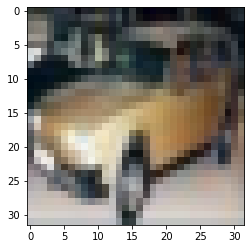

tensor(1)


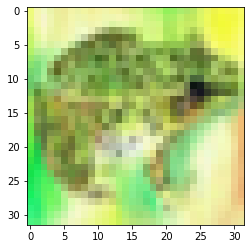

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6)


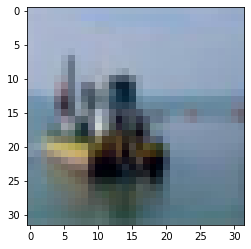

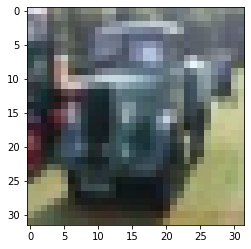

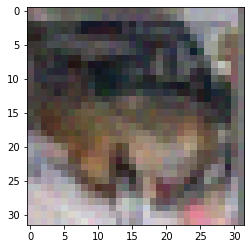

tensor([3.3643e-07, 5.1649e-01, 8.6031e-05, 3.4667e-01, 3.3124e-07, 7.0751e-04,
        1.3602e-01, 1.0185e-07, 5.4969e-06, 1.4251e-05])


In [25]:
x_imgs, x_labels = iter(train_loader).next()
u_imgs, _ = iter(train_loader).next()

show_img(x_imgs[0])
print(x_labels[0])
show_img(x_imgs[1])
print(x_labels[1])
show_img(u_imgs[0])
show_img(u_imgs[1])

mixmatch = MixMatch(model, 64, K=2)
x, u = mixmatch.run(x_imgs, x_labels, u_imgs)


x_prime = x[0]
p_prime = x[1]
u_prime = u[0]
q_prime = u[1]

show_img(x_prime[0])
print(p_prime[0])




In [ ]:
x_imgs, x_labels = iter(train_loader).next()


In [54]:
class Loss(object):

    def __init__(self, lambda_u_max, step_top_up):
        self.lambda_u_max = lambda_u_max
        self.step_top_up = step_top_up

    def __call__(self, x_output, x_target, u_output, u_target, step):
        lambda_u = self.ramp_up_lambda(step)
        mse_loss = nn.MSELoss()
        u_output = torch.softmax(u_output, dim=1)
        print(torch.log_softmax(x_output, dim=1)[0])
        lx = - torch.mean(torch.sum(x_target * torch.log_softmax(x_output, dim=1), dim=1))
        lu = mse_loss(u_output, u_target)
        loss = lx + lu * lambda_u

        return loss.item(), lx.item(), (lu * lambda_u).item()

    def ramp_up_lambda(self, step):
        if step > self.step_top_up:
            return self.lambda_u_max
        else:
            return self.lambda_u_max * step / self.step_top_up
